___________________________________________

# Compulsory Part

### Download the dataset

Download the dataset from the following link: https://drive.switch.ch/index.php/s/pfQxPuSlVdNkgYI?path=%2FGroup%206%20-%20KrishnanMolCellProt2021

put the downloaded file in the same directory as this notebook

### Load the necessary libraries

Use anaconda prompt to install the environment with the following command and the necessary libraries
```bash
conda create --name bioinfoWG python=3.9
conda activate bioinfoWG

conda install pandas numpy scikit-learn scipy matplotlib seaborn ipywidgets
pip install umap-learn
pip install openpyxl
conda install ipykernel
python -m ipykernel install --user --name=bioinfo --display-name "Python (bioinfoWG)"

```

Then run all the cell below

In [1]:
import pandas as pd
import numpy as np
import openpyxl

import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from scipy import stats
from scipy.cluster.hierarchy import linkage

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

import ipywidgets as widgets
from IPython.display import display


________________________

### Data exploration

We first expore the data to understand the structure of the saved data. The data is saved in a excel file and several tables are saved on the same sheet. We have to identify the tables and load them into pandas dataframes.

In [2]:
# load the excel file
file_name = "Original_Scale_data.xlsx"
df = pd.read_excel(file_name)

In [3]:
#explore the data (metabolic data)
df.head(10)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,EDTA Plasma.62,EDTA Plasma.63,EDTA Plasma.64,EDTA Plasma.65,EDTA Plasma.66,EDTA Plasma.67,EDTA Plasma.68,EDTA Plasma.69,EDTA Plasma.70,EDTA Plasma.71
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Hospitalised_Mild_SE,Hospitalised_Mild_SE,COVID19_Convalescent,Hospitalised_Mild_SE,Hospitalised_Severe_SE,COVID19_NEG,COVID19_NEG,COVID19_Convalescent,Hospitalised_Severe_SE,Hospitalised_Mild_SE
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Male,Male,Male,Male,Male,Male,Male,Female,Female,Female
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,64,48,66,59,58,48,59,54,50,64
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100,100,100,100,100,100,100,100,100,100
4,PATHWAY_SORTORDER,BIOCHEMICAL,COMP_ID,PLATFORM,CHEMICAL_ID,RI,MASS,PUBCHEM,CAS,KEGG,...,FR15458310,FR15458391,FR15467288,FR15465911,FR15459396,FR15458485,FR15459830,FR15467443,FR15459658,FR15459732
5,1642,(14 or 15)-methylpalmitate (a17:0 or i17:0),38768,LC/MS Neg,100002945,5695,269.2487,8181;17903417,NaN,C16995,...,NaN,24383918,8025137,5301437,10309669,7389532,21441622,7722744,18569160,15214705
6,4717,(15:2)-anacardic acid,41397,LC/MS Neg,100003472,5565,343.2279,11824131,11034-77-8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4718,(15:3)-anacardic acid,64092,LC/MS Neg,100021253,5483,341.2122,9875131,103904-73-0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1648,(16 or 17)-methylstearate (a19:0 or i19:0),38296,LC/MS Neg,100002356,5993,297.2799,3083779,2724-59-6,NaN,...,675011.06,1134181.5,651372.13,514062.19,1003399.25,635629,1984505.38,980257.31,1372987,1663296
9,1498,(2 or 3)-decenoate (10:1n7 or n8),63436,LC/MS Neg,100021502,4990,169.1234,NaN,NaN,NaN,...,132534.52,155680.88,78525.73,355212.53,144544.11,200414.17,885024.88,438756.38,201497.05,436376.16


We want to extract a sub part of the table: columns 1 to 9 and row from 4 to the end, this is where the metabolite are stored

In [4]:
# We extract a sub part of the table: columns 1 to 9 and row from 4 to the end
df_1 = df.iloc[4:, 0:11]
# select row 1 as the header
df_1.columns = df_1.iloc[0, :]
# remove the first row
df_1 = df_1.iloc[1:, :]
df_1.head(1)

4,PATHWAY_SORTORDER,BIOCHEMICAL,COMP_ID,PLATFORM,CHEMICAL_ID,RI,MASS,PUBCHEM,CAS,KEGG,Group HMDB
5,1642,(14 or 15)-methylpalmitate (a17:0 or i17:0),38768,LC/MS Neg,100002945,5695,269.2487,8181;17903417,NaN,C16995,HMDB0061859


we check that the pathway names are unique (that there is no duplicates) and that the comp_ID are unique as well.

In [5]:
# show non-unique element in the PATHWAY_SORTORDER and extract the non-unique values
non_unique = df_1['PATHWAY_SORTORDER'].value_counts()
non_unique = non_unique[non_unique > 1]

if len(non_unique) > 0:
    print("Non-unique values in the column PATHWAY_SORTORDER:")
    print(non_unique)
else:
    print("No non-unique values in the column PATHWAY_SORTORDER")
    
non_unique = df_1['COMP_ID'].value_counts()
non_unique = non_unique[non_unique > 1]

if len(non_unique) > 0:
    print("Non-unique values in the column COMP_ID:")
    print(non_unique)
else:
    print("No non-unique values in the column COMP_ID")

No non-unique values in the column PATHWAY_SORTORDER
No non-unique values in the column COMP_ID


In [6]:
# extract the second half of the table -> the metabolic data of interest are here
df_2 = df.iloc[:,10:]
df_2.head()


,CLIENT MATRIX,EDTA Plasma,EDTA Plasma.1,EDTA Plasma.2,EDTA Plasma.3,EDTA Plasma.4,EDTA Plasma.5,EDTA Plasma.6,EDTA Plasma.7,EDTA Plasma.8,...,EDTA Plasma.62,EDTA Plasma.63,EDTA Plasma.64,EDTA Plasma.65,EDTA Plasma.66,EDTA Plasma.67,EDTA Plasma.68,EDTA Plasma.69,EDTA Plasma.70,EDTA Plasma.71
0,GROUP NAME,Hospitalised_Mild_SE,Hospitalised_Mild_SE,Hospitalised_Severe_SE,COVID19_NEG,COVID19_NEG,Hospitalised_Mild_SE,COVID19_NEG,Hospitalised_Mild_SE,Hospitalised_Mild_SE,...,Hospitalised_Mild_SE,Hospitalised_Mild_SE,COVID19_Convalescent,Hospitalised_Mild_SE,Hospitalised_Severe_SE,COVID19_NEG,COVID19_NEG,COVID19_Convalescent,Hospitalised_Severe_SE,Hospitalised_Mild_SE
1,GENDER,Male,Female,Male,Male,Male,Male,Female,Male,Male,...,Male,Male,Male,Male,Male,Male,Male,Female,Female,Female
2,AGE,66,38,39,46,60,32,55,50,59,...,64,48,66,59,58,48,59,54,50,64
3,VOLUME EXTRACTION,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
4,Group HMDB,FR15466978,FR15467218,FR15460157,FR16956500,FR15467367,FR16956386,FR15460217,FR15459792,FR15457920,...,FR15458310,FR15458391,FR15467288,FR15465911,FR15459396,FR15458485,FR15459830,FR15467443,FR15459658,FR15459732


Paste the biochemical information at the right place in the code below

In [7]:
df_2.iloc[5:, 0] = df_1['BIOCHEMICAL'].values

C:\Users\gross\AppData\Local\Temp\ipykernel_16292\4226460150.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.iloc[5:, 0] = df_1['BIOCHEMICAL'].values


In [8]:
# show the row 3-6 of the table -> to check if the values are correctly copied
df_2.iloc[3:7, :]

,CLIENT MATRIX,EDTA Plasma,EDTA Plasma.1,EDTA Plasma.2,EDTA Plasma.3,EDTA Plasma.4,EDTA Plasma.5,EDTA Plasma.6,EDTA Plasma.7,EDTA Plasma.8,...,EDTA Plasma.62,EDTA Plasma.63,EDTA Plasma.64,EDTA Plasma.65,EDTA Plasma.66,EDTA Plasma.67,EDTA Plasma.68,EDTA Plasma.69,EDTA Plasma.70,EDTA Plasma.71
3,VOLUME EXTRACTION,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
4,Group HMDB,FR15466978,FR15467218,FR15460157,FR16956500,FR15467367,FR16956386,FR15460217,FR15459792,FR15457920,...,FR15458310,FR15458391,FR15467288,FR15465911,FR15459396,FR15458485,FR15459830,FR15467443,FR15459658,FR15459732
5,(14 or 15)-methylpalmitate (a17:0 or i17:0),10535261,22204970,18332000,9545369,15353830,14214526,10986852,6470628.5,20316628,...,NaN,24383918,8025137,5301437,10309669,7389532,21441622,7722744,18569160,15214705
6,(15:2)-anacardic acid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# we transpose the table df_2
df_2 = df_2.T
df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090
CLIENT MATRIX,GROUP NAME,GENDER,AGE,VOLUME EXTRACTION,Group HMDB,(14 or 15)-methylpalmitate (a17:0 or i17:0),(15:2)-anacardic acid,(15:3)-anacardic acid,(16 or 17)-methylstearate (a19:0 or i19:0),(2 or 3)-decenoate (10:1n7 or n8),...,vanillic acid glycine,vanillic alcohol sulfate,vanillylmandelate (VMA),venlafaxine,warfarin,xanthine,xanthosine,xanthurenate,ximenoylcarnitine (C26:1)*,xylose
EDTA Plasma,Hospitalised_Mild_SE,Male,66,100,FR15466978,10535261,NaN,NaN,1036539.38,226616.92,...,NaN,NaN,123908.88,NaN,NaN,8567009,29773.63,NaN,359332.25,405269.31
EDTA Plasma.1,Hospitalised_Mild_SE,Female,38,100,FR15467218,22204970,NaN,NaN,969547.31,168184.66,...,1760269.88,414896.19,354871.25,NaN,NaN,3243884.5,NaN,65157.93,745461.38,323868.66
EDTA Plasma.2,Hospitalised_Severe_SE,Male,39,100,FR15460157,18332000,NaN,NaN,938767.25,189252.94,...,NaN,NaN,223752.08,NaN,NaN,14177376,32016.96,59276.02,229998.52,558657.56
EDTA Plasma.3,COVID19_NEG,Male,46,100,FR16956500,9545369,NaN,NaN,1042588.69,268424.47,...,211231.58,25563.53,272021.81,NaN,NaN,3682648.75,NaN,83069,524256.59,315995.81


In [10]:
# define the first row as the header
df_2.columns = df_2.iloc[0, :]
#remove the first row
df_2 = df_2.iloc[1:, :]
#remove columns 2,3,4,5
columns_to_remove = [1, 2, 3, 4, 5]
df_2 = df_2.drop(df_2.columns[columns_to_remove], axis=1)

df_2.head()

CLIENT MATRIX,GROUP NAME,(15:2)-anacardic acid,(15:3)-anacardic acid,(16 or 17)-methylstearate (a19:0 or i19:0),(2 or 3)-decenoate (10:1n7 or n8),"(2,4 or 2,5)-dimethylphenol sulfate",(N(1) + N(8))-acetylspermidine,(R)-3-hydroxybutyrylcarnitine,(S)-3-hydroxybutyrylcarnitine,(S)-a-amino-omega-caprolactam,...,vanillic acid glycine,vanillic alcohol sulfate,vanillylmandelate (VMA),venlafaxine,warfarin,xanthine,xanthosine,xanthurenate,ximenoylcarnitine (C26:1)*,xylose
EDTA Plasma,Hospitalised_Mild_SE,NaN,NaN,1036539.38,226616.92,NaN,649249.81,117466.31,NaN,81572.82,...,NaN,NaN,123908.88,NaN,NaN,8567009,29773.63,NaN,359332.25,405269.31
EDTA Plasma.1,Hospitalised_Mild_SE,NaN,NaN,969547.31,168184.66,NaN,533734.81,136193.53,163693.52,167344.05,...,1760269.88,414896.19,354871.25,NaN,NaN,3243884.5,NaN,65157.93,745461.38,323868.66
EDTA Plasma.2,Hospitalised_Severe_SE,NaN,NaN,938767.25,189252.94,NaN,498711.72,NaN,NaN,141377.48,...,NaN,NaN,223752.08,NaN,NaN,14177376,32016.96,59276.02,229998.52,558657.56
EDTA Plasma.3,COVID19_NEG,NaN,NaN,1042588.69,268424.47,39255.87,363547.06,135565.81,141850.97,176184.09,...,211231.58,25563.53,272021.81,NaN,NaN,3682648.75,NaN,83069,524256.59,315995.81
EDTA Plasma.4,COVID19_NEG,NaN,NaN,1724627.88,608721.5,79884.66,276387.81,209659.53,NaN,134684.73,...,307959.34,NaN,379990.88,NaN,NaN,3437032,NaN,50447.95,1185622.63,339599.59


We successfully manipulate the data and extract the necessary information. We can now move to the next step : the data cleaning

Now that we identified the data and we successfully isolated the data frame of interest we can start the process of cleaning the data.  We clean the unnecessary data and save the cleaned data in a new file. We remove the metabolite that have more than 20% of missing information, while below we complete the missing data with the mean of the metabolite.

In [11]:
# check if the rownames are unique (client matrix)
rownames = df_2.index.value_counts()
rownames = rownames[rownames > 1]
if len(rownames) > 0:
    print("Non-unique rownames:")
    print(rownames)
else:
    print("All rownames are unique")

All rownames are unique


In [12]:
# Let's clean the data

# Initial number of columns and rows
initial_cols = df_2.shape[1]
initial_rows = df_2.shape[0]

# Count columns with more than 20% missing values
cols_to_drop = df_2.columns[df_2.isnull().mean() > 0.2]
percentage_cols_removed = len(cols_to_drop) / initial_cols * 100

# Remove all the columns that have more than 20% of missing values
df_2 = df_2.drop(columns=cols_to_drop)

# Count rows with more than 20% missing values
rows_to_drop = df_2.index[df_2.isnull().mean(axis=1) > 0.2]
percentage_rows_removed = len(rows_to_drop) / initial_rows * 100

# Remove all the rows that have more than 20% of missing values
df_2 = df_2.drop(index=rows_to_drop)

# Output the percentages of removed columns and rows
print(f"Percentage of columns removed: {percentage_cols_removed}%")
print(f"Percentage of rows removed: {percentage_rows_removed}%")

# Display the first few rows of the updated DataFrame
df_2.head()


Percentage of columns removed: 25.04604051565378%
Percentage of rows removed: 0.0%


CLIENT MATRIX,GROUP NAME,(16 or 17)-methylstearate (a19:0 or i19:0),(2 or 3)-decenoate (10:1n7 or n8),(N(1) + N(8))-acetylspermidine,(S)-3-hydroxybutyrylcarnitine,(S)-a-amino-omega-caprolactam,"1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",...,urate,urea,uridine,valerate (5:0),valine,vanillactate,vanillylmandelate (VMA),xanthine,ximenoylcarnitine (C26:1)*,xylose
EDTA Plasma,Hospitalised_Mild_SE,1036539.38,226616.92,649249.81,NaN,81572.82,40270140,230671.42,23592224,119566232,...,76805128,149654272,14390532,153467.23,1016393728,67225.55,123908.88,8567009,359332.25,405269.31
EDTA Plasma.1,Hospitalised_Mild_SE,969547.31,168184.66,533734.81,163693.52,167344.05,39550232,425440.5,28891032,60207636,...,105044496,83316008,12925825,292986.56,798844864,112559.15,354871.25,3243884.5,745461.38,323868.66
EDTA Plasma.2,Hospitalised_Severe_SE,938767.25,189252.94,498711.72,NaN,141377.48,16026598,199090.94,27781060,111467376,...,105232736,87635176,12769002,150189.59,727650432,58210.46,223752.08,14177376,229998.52,558657.56
EDTA Plasma.3,COVID19_NEG,1042588.69,268424.47,363547.06,141850.97,176184.09,101937016,375988.03,30103428,51274616,...,109683296,300178144,18798366,NaN,1023975232,112064.68,272021.81,3682648.75,524256.59,315995.81
EDTA Plasma.4,COVID19_NEG,1724627.88,608721.5,276387.81,NaN,134684.73,78726488,NaN,27322866,72727336,...,146875600,116461600,16890914,102464.16,745741888,142348.72,379990.88,3437032,1185622.63,339599.59


We removed 25 percent of all metabolites because they had more than 20% of missing data. But we did not remove a single individual (sample)

In [13]:
#if in the column group name there is a missing value, we remove the row -> we don't know to which metabolite the data belongs, so we can't use it
df_2 = df_2.dropna(subset=['GROUP NAME'])


In [14]:
#complete the few remaining missing values with the median/mean/ min of the corresponding column (we decided to choose the mean as the added values will not affect the variance of the data)

#fill the missing values with the mean of the corresponding column
df_2.iloc[:, 1:] = df_2.iloc[:, 1:].apply(lambda x: x.fillna(x.mean()), axis=0)
df_2.iloc[:, 1:] = df_2.iloc[:, 1:].apply(lambda x: x.fillna(0), axis=0)

df_2.head()

C:\Users\gross\AppData\Local\Temp\ipykernel_16292\1093500294.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_2.iloc[:, 1:] = df_2.iloc[:, 1:].apply(lambda x: x.fillna(x.mean()), axis=0)
C:\Users\gross\AppData\Local\Temp\ipykernel_16292\1093500294.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_2.iloc[:, 1:] = df_2.iloc[:, 1:].apply(lambda x: x.fillna(0), axis=0)


CLIENT MATRIX,GROUP NAME,(16 or 17)-methylstearate (a19:0 or i19:0),(2 or 3)-decenoate (10:1n7 or n8),(N(1) + N(8))-acetylspermidine,(S)-3-hydroxybutyrylcarnitine,(S)-a-amino-omega-caprolactam,"1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",...,urate,urea,uridine,valerate (5:0),valine,vanillactate,vanillylmandelate (VMA),xanthine,ximenoylcarnitine (C26:1)*,xylose
EDTA Plasma,Hospitalised_Mild_SE,1036539.38,226616.92,649249.81,392950.006552,81572.82,40270140.0,230671.42,23592224,119566232.0,...,76805128,149654272,14390532.0,153467.23,1016393728,67225.55,123908.88,8567009.0,359332.25,405269.31
EDTA Plasma.1,Hospitalised_Mild_SE,969547.31,168184.66,533734.81,163693.52,167344.05,39550232.0,425440.5,28891032,60207636.0,...,105044496,83316008,12925825.0,292986.56,798844864,112559.15,354871.25,3243884.5,745461.38,323868.66
EDTA Plasma.2,Hospitalised_Severe_SE,938767.25,189252.94,498711.72,392950.006552,141377.48,16026598.0,199090.94,27781060,111467376.0,...,105232736,87635176,12769002.0,150189.59,727650432,58210.46,223752.08,14177376.0,229998.52,558657.56
EDTA Plasma.3,COVID19_NEG,1042588.69,268424.47,363547.06,141850.97,176184.09,101937016.0,375988.03,30103428,51274616.0,...,109683296,300178144,18798366.0,239546.308676,1023975232,112064.68,272021.81,3682648.75,524256.59,315995.81
EDTA Plasma.4,COVID19_NEG,1724627.88,608721.5,276387.81,392950.006552,134684.73,78726488.0,441330.171094,27322866,72727336.0,...,146875600,116461600,16890914.0,102464.16,745741888,142348.72,379990.88,3437032.0,1185622.63,339599.59


In [15]:
# Rename the group names to be more descriptive (and use the same names as in the paper)
replacement_dict = {
    'Hospitalised_Mild_SE': 'Hospitalised-mild',
    'Hospitalised_Severe_SE': 'Hospitalised-severe',
    'COVID19_Convalescent': 'HC (Cov-2 Ab+)',
    'COVID19_NEG': 'Healthy Control (HC)'
}

df_2['GROUP NAME'] = df_2['GROUP NAME'].replace(replacement_dict)


Save normalized data and unnormalized data in a new file

In [16]:
# save the uniformalized data
df_2_not_uniformalized = df_2.copy()
df_2_not_uniformalized.to_csv("metabolomics_not_uniformalized.csv", index=False)


# Normalize the data

# Get the column names for all columns except the first one
cols = df_2.columns[1:]

# Loop over each column
for col in cols:
    #divide by the norm 
    df_2[col] = df_2[col].astype(float)
    df_2[col] = df_2[col] / np.linalg.norm(df_2[col])

df_2.head(2)

CLIENT MATRIX,GROUP NAME,(16 or 17)-methylstearate (a19:0 or i19:0),(2 or 3)-decenoate (10:1n7 or n8),(N(1) + N(8))-acetylspermidine,(S)-3-hydroxybutyrylcarnitine,(S)-a-amino-omega-caprolactam,"1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",...,urate,urea,uridine,valerate (5:0),valine,vanillactate,vanillylmandelate (VMA),xanthine,ximenoylcarnitine (C26:1)*,xylose
EDTA Plasma,Hospitalised-mild,0.068711,0.058839,0.109294,0.091571,0.066005,0.081025,0.049622,0.096259,0.146609,...,0.069716,0.116963,0.098031,0.069858,0.113605,0.067325,0.042946,0.120818,0.055129,0.056309
EDTA Plasma.1,Hospitalised-mild,0.064270,0.043668,0.089848,0.038146,0.135408,0.079577,0.091521,0.117879,0.073825,...,0.095349,0.065116,0.088053,0.133366,0.089289,0.112726,0.122997,0.045748,0.114369,0.044999


In [17]:
#save the df_2 normalized in a new csv file
pd.DataFrame.to_csv(df_2, "metabolomics_normalized.csv", index=False)

_________________________

### UMAP of metabolomics data

We use a UMAP on metabolomic data to see whether each different cohort can cluster together. We use the UMAP to reduce the dimensionality of the data and plot the data in 2D.

c:\Users\gross\anaconda3\envs\bioinfoWG\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


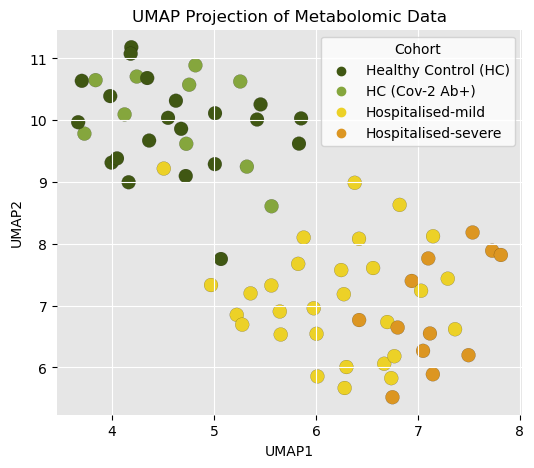

In [18]:
# Load the data
data = pd.read_csv('metabolomics_normalized.csv') 
# reorder the data frame to have in the column 'GROUP NAME' first the value of Healthy Control (HC), then HC (Cov-2 Ab+), then Hospitalised-mild and finally Hospitalised-severe
data['GROUP NAME'] = pd.Categorical(data['GROUP NAME'], ['Healthy Control (HC)', 'HC (Cov-2 Ab+)', 'Hospitalised-mild', 'Hospitalised-severe'])


# Select only numeric data for UMAP
data_numeric = data.select_dtypes(include=[float, int])
# Standardize the data
data_numeric = StandardScaler().fit_transform(data_numeric)


# choose a random state so that the results are reproducible (and look a bit similar to the paper)
random_state = 3

# Set up and fit UMAP
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    n_components=2,
    random_state=random_state
)
embedding = reducer.fit_transform(data_numeric)

# Create a DataFrame for plotting
umap_data = pd.DataFrame(embedding, columns=['UMAP-1', 'UMAP-2'])
umap_data['Cohort'] = data['GROUP NAME']

# choose colors for the dots
replacement_dict = {
    'Hospitalised-mild': '#ecd127',
    'Hospitalised-severe': '#dc9622',
    'HC (Cov-2 Ab+)': '#85a63d',
    'Healthy Control (HC)': '#405713'
}


# Plotting
plt.figure(figsize=(6, 5))
sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='Cohort', data=umap_data, palette=replacement_dict, s=100, alpha=1, linewidth=0.1, edgecolor='black')
xlabel = plt.xlabel('UMAP1')
ylabel = plt.ylabel('UMAP2')
#put a gray background
plt.gca().set_facecolor("#e6e6e6")
#add a white grid
plt.grid(color='white')
#remove the black frame
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

#add the title
plt.title('UMAP Projection of Metabolomic Data')
plt.legend(title='Cohort')
plt.show()


The UMAP shows that the healthy and the disease cohort are well separated. They are not clustering together. However, the two disease cohorts are not well separated meaning that the metabolite expression in two disease cohorts are very similar.

_________________________

### Metabolomics heatmap

We use a heatmap to visualize the metabolomics data and see what metabolites are differently present between the cohorts.

In [19]:
# Reload the data
df_2_not_uniformalized = pd.read_csv('metabolomics_not_uniformalized.csv')
#rename the column 'GROUP NAME' to 'Cohort'
df_2_not_uniformalized = df_2_not_uniformalized.rename(columns={'GROUP NAME': 'Cohort'})

In [20]:
#reexplore the data
df_2_not_uniformalized.head()

,Cohort,(16 or 17)-methylstearate (a19:0 or i19:0),(2 or 3)-decenoate (10:1n7 or n8),(N(1) + N(8))-acetylspermidine,(S)-3-hydroxybutyrylcarnitine,(S)-a-amino-omega-caprolactam,"1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",...,urate,urea,uridine,valerate (5:0),valine,vanillactate,vanillylmandelate (VMA),xanthine,ximenoylcarnitine (C26:1)*,xylose
0,Hospitalised-mild,1036539.38,226616.92,649249.81,392950.006552,81572.82,40270140.0,230671.420000,23592224,119566232.0,...,76805128,149654272,14390532.0,153467.230000,1016393728,67225.55,123908.88,8567009.00,359332.25,405269.31
1,Hospitalised-mild,969547.31,168184.66,533734.81,163693.520000,167344.05,39550232.0,425440.500000,28891032,60207636.0,...,105044496,83316008,12925825.0,292986.560000,798844864,112559.15,354871.25,3243884.50,745461.38,323868.66
2,Hospitalised-severe,938767.25,189252.94,498711.72,392950.006552,141377.48,16026598.0,199090.940000,27781060,111467376.0,...,105232736,87635176,12769002.0,150189.590000,727650432,58210.46,223752.08,14177376.00,229998.52,558657.56
3,Healthy Control (HC),1042588.69,268424.47,363547.06,141850.970000,176184.09,101937016.0,375988.030000,30103428,51274616.0,...,109683296,300178144,18798366.0,239546.308676,1023975232,112064.68,272021.81,3682648.75,524256.59,315995.81
4,Healthy Control (HC),1724627.88,608721.50,276387.81,392950.006552,134684.73,78726488.0,441330.171094,27322866,72727336.0,...,146875600,116461600,16890914.0,102464.160000,745741888,142348.72,379990.88,3437032.00,1185622.63,339599.59


perform the t-test for each metabolite to determine the p-value. We compare mild vs severe condition.

In [21]:
def metabolite_ttest(df, group_col='Cohort', group1='Hospitalised-mild', group2='Hospitalised-severe'):
    # Get the column names for all columns except the first one -> metabolite names
    metabolite_cols = df.columns[1:]
    

    # Create empty list to store result dictionaries
    results = []

    #for each metabolite, we perform a t-test
    for col in metabolite_cols:
        # Select subdata for the two groups
        group1_data = df[df[group_col] == group1][col]
        group2_data = df[df[group_col] == group2][col]

        # Perform T-test and store p-value
        _, pval = stats.ttest_ind(group1_data, group2_data)

        # Calculate log fold change
        mean_group1 = np.mean(group1_data)
        mean_group2 = np.mean(group2_data)
        log_fc = np.log2(mean_group2 / mean_group1) if mean_group1 != 0 else np.inf

        # Append results to the list
        results.append({'Metabolite': col, 'p-value': pval, 'logFC': log_fc})

    # Create the DataFrame from the list of dictionaries
    results_df = pd.DataFrame(results)

    return results_df

# Perform the t-test and save the p-values in a DataFrame
pvals_df = metabolite_ttest(df_2_not_uniformalized)
group_labels = df_2_not_uniformalized.pop('Cohort')


use of bonferoni correction to correct the p-value

In [22]:
# Define significance threshold
significance_threshold = 0.05
#adjust the significance threshold using the Bonferroni correction
significance_threshold = significance_threshold / pvals_df.shape[1]

# Filter significant metabolites using Bonferroni correction
significant_metabolites = pvals_df[pvals_df['p-value'] < significance_threshold]

#sort the significant_metabolites by p-value
significant_metabolites = significant_metabolites.sort_values('p-value')

#keep only the significant metabolites in the df_2_not_uniformalized
df_2_not_uniformalized = df_2_not_uniformalized[significant_metabolites['Metabolite']]

#count the number of significant metabolites
print(f"Number of significant metabolites that are expressed differently between the selected two groups: {len(significant_metabolites)}")

Number of significant metabolites that are expressed differently between the selected two groups: 67


We indentify 67 metabolites that are significantly different between the two cohorts. We can now plot the heatmap of these metabolites.

Calculate the log2 fold change of the metabolites between the cohorts and plot the heatmap and make a dendrogram to see the clustering of the metabolites.

In [23]:
# Log2 transformation
e = 0
df_log2 = np.log2(df_2_not_uniformalized+e)  # Adding a small constant to avoid log(0) but it should not be necessary 

# Z-score normalization
scaler = StandardScaler()
df_zscore = scaler.fit_transform(df_log2)
df_zscore = pd.DataFrame(df_zscore, columns=df_2_not_uniformalized.columns)
df_zscore = df_zscore.T


# Hierarchical clustering
linkage_matrix = linkage(df_zscore, method='average', metric='euclidean')


# Column annotations for the heatmap
replacement_dict = {
    'HC (Cov-2 Ab+)': '#85a63d',
    'Healthy Control (HC)': '#405713',
    'Hospitalised-mild': '#ecd127',
    'Hospitalised-severe': '#dc9622',
}

#set the colors of the columns
col_colors = group_labels.map(replacement_dict)

#sort the columns by group labels
sorted_df = df_zscore[group_labels.sort_values().index]
#calculate the line where the cohort changes
cohort_changes = np.where(group_labels.sort_values().values[:-1] != group_labels.sort_values().values[1:])[0] + 1
#insert blank columns for the cohort changes
for index in cohort_changes[::-1]:
    sorted_df.insert(index, f'Blank_{index}', np.nan)


Plot the heat map of the metabolites that are differentially present between the cohorts.

<Figure size 1000x1000 with 0 Axes>

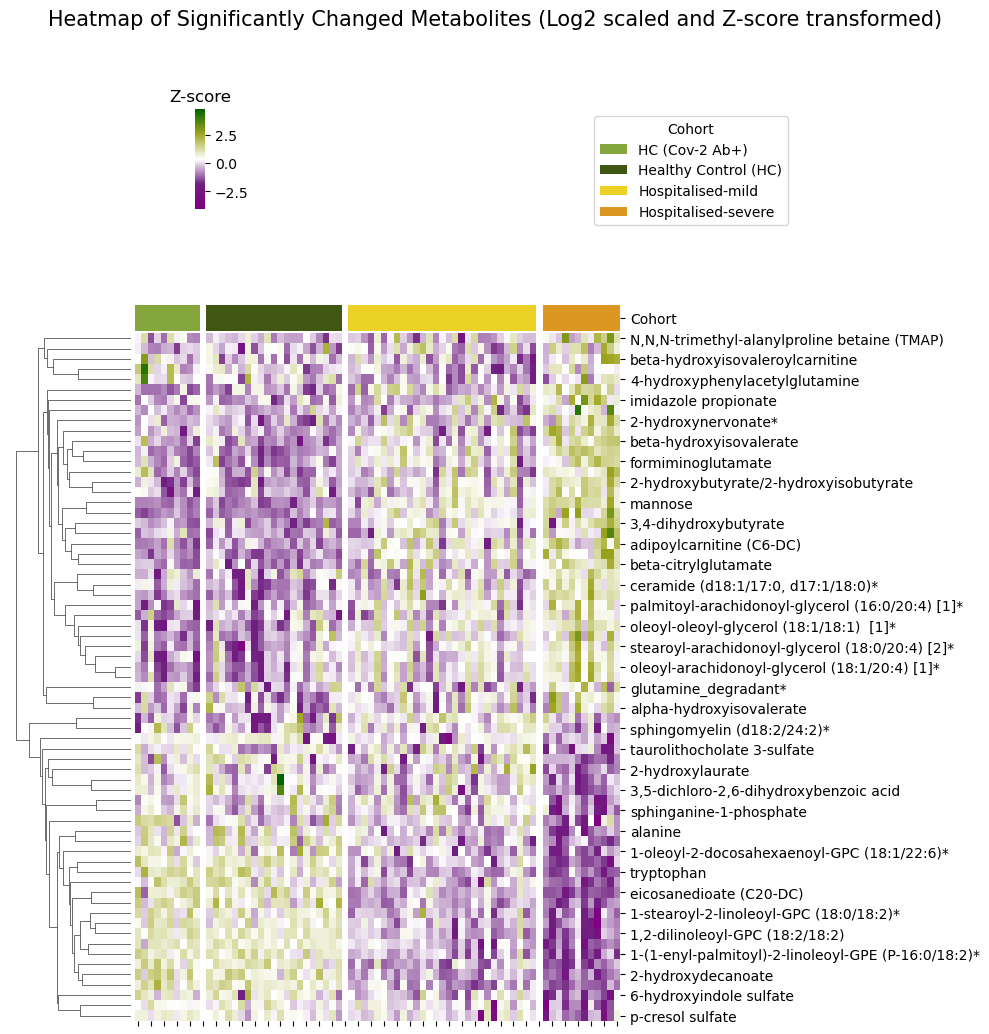

In [24]:
#plot the heatmap
fig_size = (10, 10)

# Create a custom colormap
colors = ["purple", "#6f2081", "white", "#a0a61f", "darkgreen"]
cmap_name = 'custom_cmap'
cmap_ = LinearSegmentedColormap.from_list(cmap_name, colors)
plt.figure(figsize=fig_size)

# Plot the heatmap with hierarchical clustering
clustermap = sns.clustermap(
    sorted_df,  # Transpose the sorted DataFrame
    cmap=cmap_, # Use the custom colormap for the heatmap
    row_cluster=True,  # Enable row (sample) clustering
    col_cluster=False,   # Disable column clustering
    row_linkage=linkage_matrix,  # Use the linkage matrix for row clustering
    col_colors=col_colors, # Set the column colors
    figsize=fig_size,
)

# Remove the x-axis labels
clustermap.ax_heatmap.set_xticklabels([])

# Adjust the position of the colorbar + add a title
cbar = clustermap.cax
cbar.set_position([0.2, 0.9, 0.01, 0.1])  # [left, bottom, width, height]
cbar.set_title('Z-score', fontsize=12)


# Create custom legend
handles = [Patch(facecolor=color, label=label) for label, color in replacement_dict.items()]
plt.legend(handles=handles, title='Cohort', bbox_to_anchor=(0.8, 1), bbox_transform=plt.gcf().transFigure, fontsize = 10)

#plt.title('Heatmap of Significantly Changed Metabolites (Log2 scaled and Z-score transformed)', fontsize = 15, loc = 'center')
plt.suptitle('Heatmap of Significantly Changed Metabolites (Log2 scaled and Z-score transformed)', fontsize=15, x=0.5, y=1.1)


plt.show()

Here are the metabolites that are differentially present between the mild and severe cohorts. We can see that in general the metabolites that are differentially present in mild vs sever are also ones that are strongly differently expressed between healthy and hospitalized cohorts.

______________________________________________________________

### Volcano plot
We plot all the metabolites on a volcano plot to see which metabolites are differentially present between the cohorts mild vs severe. We use the log2 fold change and the p-value to plot the volcano plot.


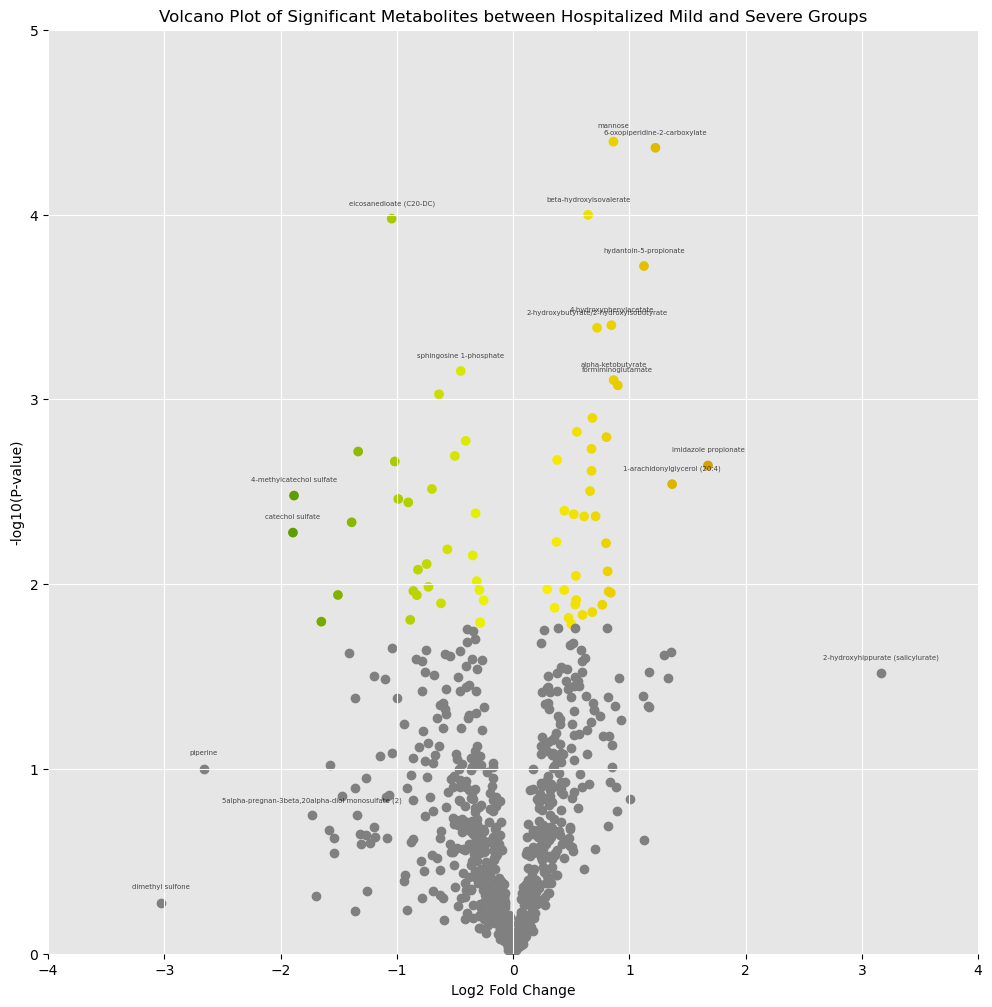

In [25]:
# Create a custom colormap from - infinity to + infinity
colors = ["darkgreen", "yellow", "darkred"]
cmap_name = 'custom_cmap'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)
# Normalize the colormap around zero
norm = TwoSlopeNorm(vmin=pvals_df['logFC'].min(), vcenter=0, vmax=pvals_df['logFC'].max())


# Separate significant and non-significant metabolites
significant_metabolites = pvals_df[pvals_df['p-value'] < significance_threshold]
non_significant_metabolites = pvals_df[pvals_df['p-value'] >= significance_threshold]


# Identify top ten smallest p-values -> to write their names in the plot
top_pvals = pvals_df.nsmallest(10, 'p-value')
# Identify top ten largest absolute log2 fold changes -> to write their names in the plot
top_logFCs = pd.concat([pvals_df.nlargest(5, 'logFC'), pvals_df.nsmallest(5, 'logFC')])
# Combine both conditions
top_annotations = pd.concat([top_pvals, top_logFCs]).drop_duplicates()


# Create the volcano plot
plt.figure(figsize=(12, 12))
plt.scatter(x=significant_metabolites['logFC'], y=-1 * np.log10(significant_metabolites['p-value']),
            c=significant_metabolites['logFC'], cmap=cmap, norm=norm, alpha=1, edgecolor=None)
plt.scatter(x=non_significant_metabolites['logFC'], y=-1 * np.log10(non_significant_metabolites['p-value']),
            c='gray', alpha=1, edgecolor=None)


# Add labels and title
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(P-value)')
plt.title('Volcano Plot of Significant Metabolites between Hospitalized Mild and Severe Groups')
# Set x and y limits
plt.xlim(-4, 4)
plt.ylim(0, 5)

# Set gray background and white grid
plt.gca().set_facecolor("#e6e6e6")
plt.grid(color='white')

# Remove the black frame
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Annotate significant points and store the texts in a list
texts = []
for i, row in top_annotations.iterrows():
    texts.append(plt.annotate(row['Metabolite'], (row['logFC'], -1 * np.log10(row['p-value'])),
                              textcoords="offset points", xytext=(0,10), ha='center', size=5, alpha=0.7))

# Add color legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.show()


From the volcano plot we can see which metabolites are differentially present between the Mild and Severe cohorts. We can see that the metabolites that are in the top right and left corner are the most differentially present between the two cohorts. We identify mannose (as in the paper) as the most differentially present metabolite between the two cohorts. (By p-value). Even though the log2 fold change is not very high, the p-value is very low, which means that the difference is significant.

Show the metabolites with the lowest adjusted p-value.

In [26]:
top_pvals.head(10)

,Metabolite,p-value,logFC
547,mannose,0.000040,0.862536
242,6-oxopiperidine-2-carboxylate,0.000044,1.223961
296,beta-hydroxyisovalerate,0.000101,0.644475
396,eicosanedioate (C20-DC),0.000105,-1.044953
492,hydantoin-5-propionate,0.000190,1.125393
210,4-hydroxyphenylacetate,0.000397,0.844976
123,2-hydroxybutyrate/2-hydroxyisobutyrate,0.000410,0.722034
752,sphingosine 1-phosphate,0.000703,-0.450608
260,alpha-ketobutyrate,0.000787,0.864469
410,formiminoglutamate,0.000840,0.900230


________________________

_______________

# Non-compulsory part

### Playground : TSNE + PCA 

Now that we have made the compulsory analysis, we can play with the data and try to see if we can find some interesting information. We can use PCA to reduce the dimensionality of the data and plot the data in 2D. We can also use PCA to see the variance explained by each component.

Select a condition :
- All condition : all the data will be used in the PCA
- Mild vs Severe : only the mild and severe cohort will be used in the PCA

Select with the button below and run the cells below to see the PCA plot.

In [27]:
# Initialize a variable to store the selected condition
selected_condition = "All Conditions"

# Define the button click functions
def on_all_conditions_click(b):
    global selected_condition
    selected_condition = "All Conditions"
    print(f"Selected condition: {selected_condition}")

def on_mild_vs_severe_click(b):
    global selected_condition
    selected_condition = "Mild vs Severe"
    print(f"Selected condition: {selected_condition}")

# Create the buttons
button_all_conditions = widgets.Button(description="All Conditions")
button_mild_vs_severe = widgets.Button(description="Mild vs Severe")

# Attach the click event handlers
button_all_conditions.on_click(on_all_conditions_click)
button_mild_vs_severe.on_click(on_mild_vs_severe_click)

# Display the buttons
print('Please select one of the button and click on run cell below')
display(button_all_conditions, button_mild_vs_severe)


Please select one of the button and click on run cell below


Button(description='All Conditions', style=ButtonStyle())

Button(description='Mild vs Severe', style=ButtonStyle())

define the data depending on the condition


In [28]:
# Load the data that were normalized previously
data = pd.read_csv('metabolomics_not_uniformalized.csv') # we will standardize the data later
# reorder the data frame to have in the column 'GROUP NAME' first the value of Healthy Control (HC), then HC (Cov-2 Ab+), then Hospitalised-mild and finally Hospitalised-severe
data['GROUP NAME'] = pd.Categorical(data['GROUP NAME'], ['Healthy Control (HC)', 'HC (Cov-2 Ab+)', 'Hospitalised-mild', 'Hospitalised-severe'])


if selected_condition == "All Conditions":
    print("All Conditions selected")
elif selected_condition == "Mild vs Severe":
    #keep only the rows with the condition 'Hospitalised-mild' and 'Hospitalised-severe'
    data = data[(data['GROUP NAME'] == 'Hospitalised-mild') | (data['GROUP NAME'] == 'Hospitalised-severe')]
    print("Mild vs Severe selected")
    
# Remoove the unused categories
data['GROUP NAME'] = data['GROUP NAME'].cat.remove_unused_categories()



All Conditions selected


TSNE non-linear dimensionality reduction -> 2D

c:\Users\gross\anaconda3\envs\bioinfoWG\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\gross\anaconda3\envs\bioinfoWG\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


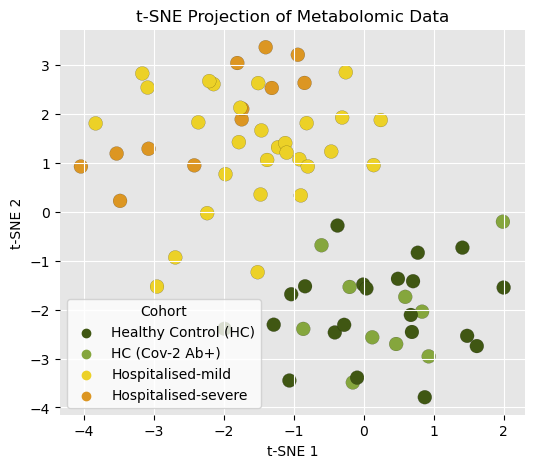

In [29]:
# numeric data for t-SNE
data_numeric = data.select_dtypes(include=[float, int])
# Standardize the data
data_numeric = StandardScaler().fit_transform(data_numeric)


# Set up and fit t-SNE
tsne = TSNE(n_components=2)
embedding = tsne.fit_transform(data_numeric)

# Create a DataFrame for plotting
tsne_data = pd.DataFrame(embedding, columns=['t-SNE-1', 't-SNE-2'])
tsne_data['Cohort'] = data['GROUP NAME']

# Define replacement_dict based on the selected condition
if selected_condition == "All Conditions":
    replacement_dict = {
        'Hospitalised-mild': '#ecd127',
        'Hospitalised-severe': '#dc9622',
        'HC (Cov-2 Ab+)': '#85a63d',
        'Healthy Control (HC)': '#405713'
    }
elif selected_condition == "Mild vs Severe":
    replacement_dict = {
        'Hospitalised-mild': '#ecd127',
        'Hospitalised-severe': '#dc9622'
    }

# Plotting
plt.figure(figsize=(6, 5))
sns.scatterplot(x='t-SNE-1', y='t-SNE-2', hue='Cohort', data=tsne_data, palette=replacement_dict, s=100, alpha=1, linewidth=0.1, edgecolor='black')
# Add labels and title
xlabel = plt.xlabel('t-SNE 1')
ylabel = plt.ylabel('t-SNE 2')

# Put a gray background
plt.gca().set_facecolor("#e6e6e6")
# Add a white grid
plt.grid(color='white')
# Remove the black frame
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Add the title and legend and plot
plt.title('t-SNE Projection of Metabolomic Data')
plt.legend(title='Cohort')
plt.show()


PCA 
linear dimensionality reduction, we identify the components that explain the most variance in the data. And then extract the loadings of the metabolites on the first components. The metabolites that have the highest loadings are the metabolites that explain the most variance in the data.

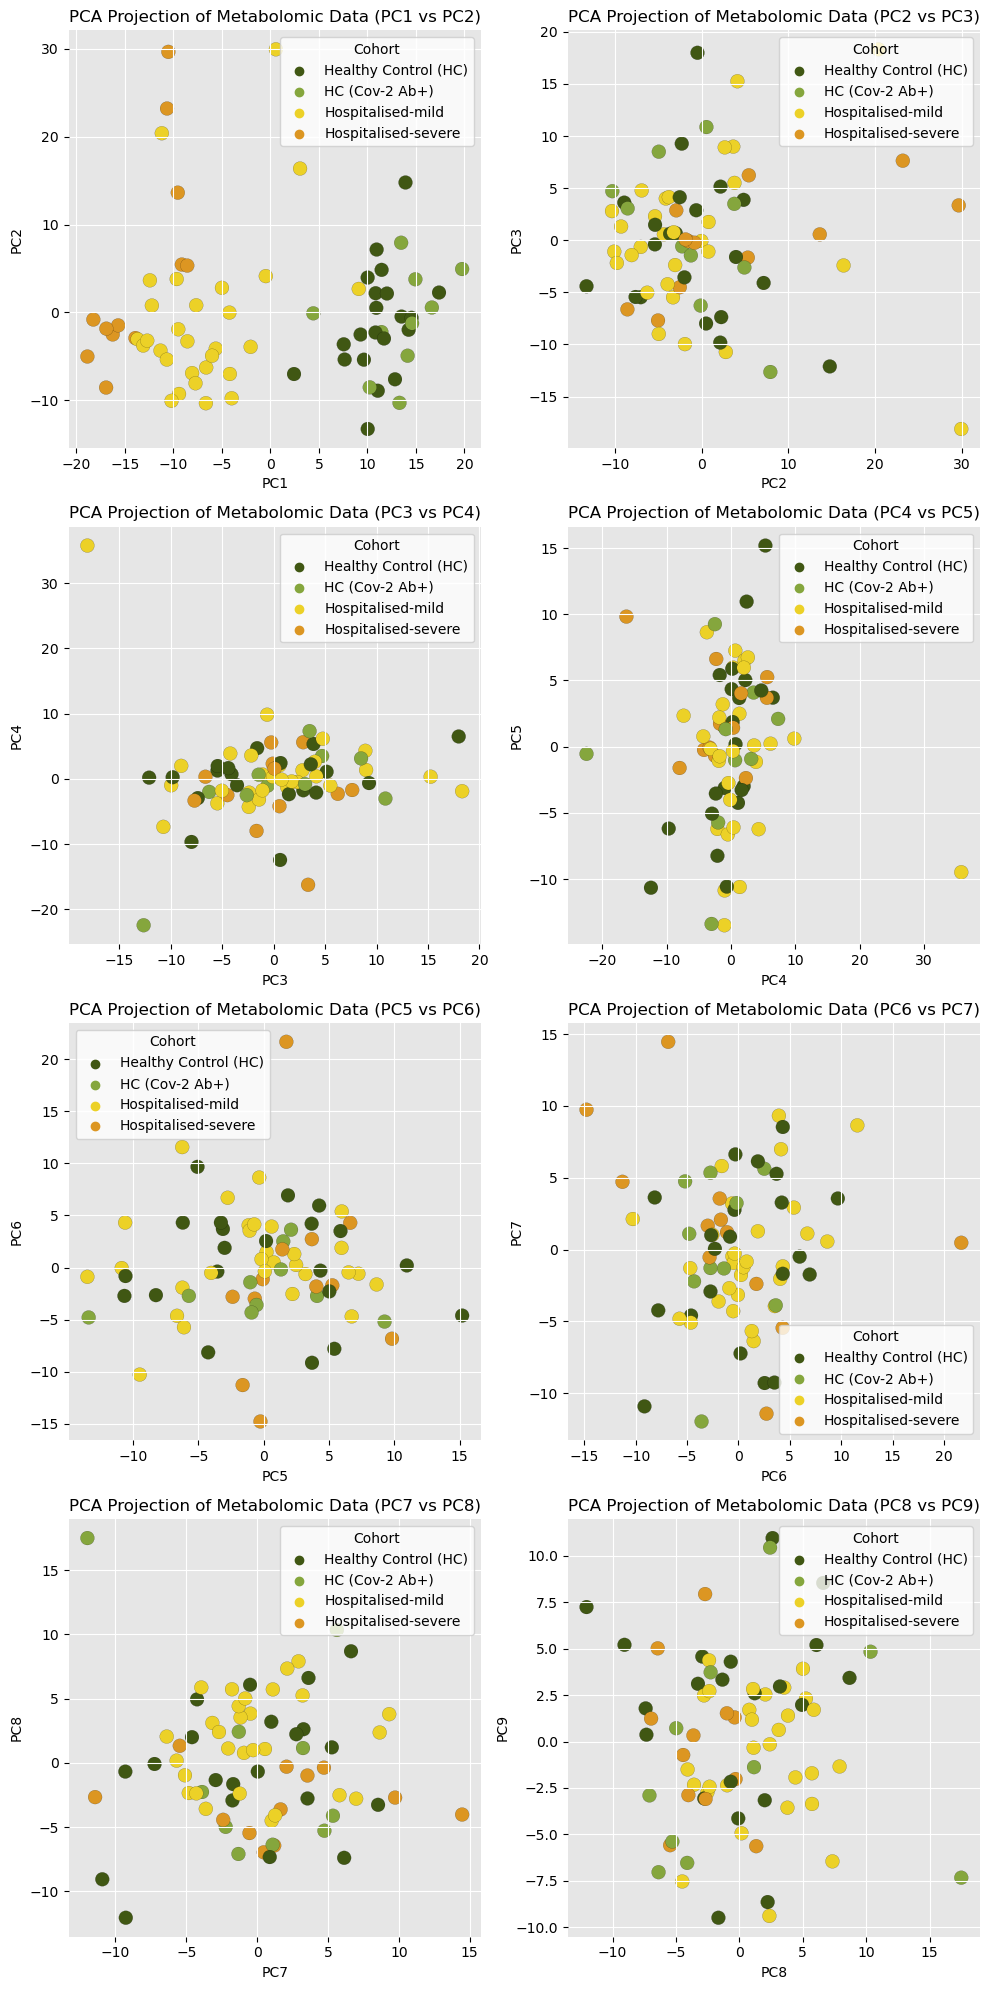

In [30]:
# Set up and fit PCA
pca = PCA(n_components=10)
pca_data = pca.fit_transform(data_numeric)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame for plotting
pca_data_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(10)])
pca_data_df['Cohort'] = data['GROUP NAME']

# Define replacement_dict as in your previous code
if selected_condition == "All Conditions":
    replacement_dict = {
        'Hospitalised-mild': '#ecd127',
        'Hospitalised-severe': '#dc9622',
        'HC (Cov-2 Ab+)': '#85a63d',
        'Healthy Control (HC)': '#405713'
    }
elif selected_condition == "Mild vs Severe":
    replacement_dict = {
        'Hospitalised-mild': '#ecd127',
        'Hospitalised-severe': '#dc9622'
    }
    


# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

# Flatten the array of axes, which makes them easier to iterate over
axes = axes.flatten()

for j in range(1, 9):
    
    #chose to plot PC1 vs PC2, ..., PC8 vs PC9
    i = j- 1
    #chose to plot PC1 vs PC2, ..., PC1 vs PC9
    #i=0
    
    # Calculate row and column index for the current subplot
    row = (j - 1) // 2
    col = (j - 1) % 2
    ax = axes[j - 1]

    # Create scatter plot for each pair of principal components
    sns.scatterplot(ax=ax, x=f'PC{i+1}', y=f'PC{j+1}', hue='Cohort', data=pca_data_df, palette=replacement_dict, s=100, alpha=1, linewidth=0.1, edgecolor='black')
    
    # Set labels and title for each subplot
    ax.set_xlabel(f'PC{i+1}')
    ax.set_ylabel(f'PC{j+1}')
    ax.set_title(f'PCA Projection of Metabolomic Data (PC{i+1} vs PC{j+1})')

    # Customize the plot appearance
    ax.set_facecolor("#e6e6e6")
    ax.grid(color='white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Adjust the layout so that subplots fit into the figure area
plt.tight_layout()

# Show the plot
plt.show()



We can see that in the first the Healthy Control and the Hospitalized Control are clustering apart. This is a good sign that the metabolites are different between the two cohorts. (whereas the Mild and Severe cohort are clustering together). We can probably easily separate the Healthy Control and the Hospitalized Control with a classifier.
While this is not the case for the Mild and Severe cohort.

Let's see what are the explained variance of the 10 first components.

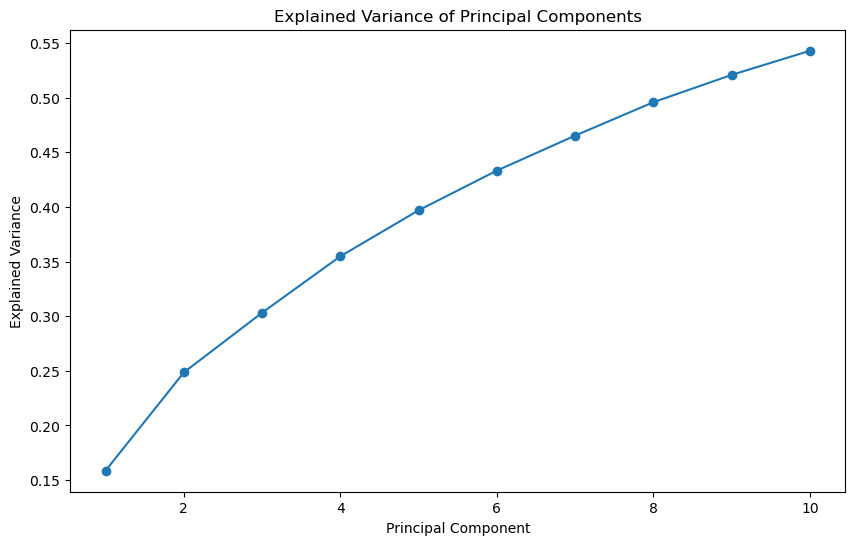

In [31]:
#show the curve of the explained variance of the PCA summed up
sum_of_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# plot the figure
plt.figure(figsize=(10, 6))
#show for the first 10 principal components
plt.plot(range(1, 11), sum_of_explained_variance, marker='o')

#add labels
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance of Principal Components')
plt.show()

Identify the metabolites that have the highest loadings on the first components. These metabolites are the metabolites that explain the most variance in the data.

In [32]:
# Get metabolite names
metabolite_names = data.columns[1:]
# Get the loadings for the first principal component -> how much each original variable contributes to the first principal component.
pc_loadings = loadings[:,0] # take only for the first principal component

In [33]:
# Find top 10 contributing metabolites for the first principal component
top_metabolites = {}

# we take the absolute value of the loadings
abs_loadings = np.abs(pc_loadings)

# sort the absolute loadings
top_metabolites_idx = np.argsort(abs_loadings)[::-1]  # Reverse the order to get the top values

#get the top metabolites names
top_metabolite_names = metabolite_names[top_metabolites_idx]

# get the top metabolites loadings
top_metabolite_loadings = pc_loadings[top_metabolites_idx]

#save in a dictionary the top metabolites
top_metabolites = {'Metabolites': top_metabolite_names, 'Loadings': top_metabolite_loadings}



In [34]:
# Save the top metabolites in a DataFrame
df_top_metabolite = pd.DataFrame(top_metabolites)

# Display the DataFrame
df_top_metabolite.head(10)

,Metabolites,Loadings
0,"1,2-dilinoleoyl-GPC (18:2/18:2)",0.875638
1,3-formylindole,0.873751
2,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,0.850327
3,allantoin,0.831364
4,6-bromotryptophan,0.828062
5,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/1...,0.823787
6,5-methyluridine (ribothymidine),0.819943
7,1-(1-enyl-stearoyl)-2-linoleoyl-GPE (P-18:0/18...,0.819634
8,1-linoleoyl-2-linolenoyl-GPC (18:2/18:3)*,0.813628
9,1-stearoyl-GPC (18:0),0.809403


We can see that these are not the same metabolites that are differentially present as in the volcano plot. The volcano plot is based on the p-value and the log2 fold change, while the PCA is based on the variance explained by the metabolites. It is interesting to see that the metabolites that explain the most variance in the data are not the same as the metabolites identified in the volcano plot.

In [35]:
#save the df in a csv file
pd.DataFrame.to_csv(df_top_metabolite, "top_metabolites.csv", index=False)

____________________________


### Predict the condition using metabolomics
Machine learning : classification 
(Logistic regression & Support Vector Machine)

We have seen that in the PCA plot the Healthy Control and the Hospitalized Control are clustering apart. Let's see if we can predict the condition of the patients using the metabolomics data.

Before that we need to know the proportion of each cohort in the data.

/!\ DISCLAIMER : The number of sample is quite low, so the prediction might not be very accurate. However, it is interesting to see if the metabolomics data can predict the condition of the patients. It would be better to have more samples to have a better prediction.

In [36]:
#show the proportion of the different labels
pca_data_df['Cohort'].value_counts(normalize=True)

Cohort
Hospitalised-mild       0.402778
Healthy Control (HC)    0.291667
Hospitalised-severe     0.166667
HC (Cov-2 Ab+)          0.138889
Name: proportion, dtype: float64

For Hospitalised:0.569444, Healthy Control (HC) : 0.430556, we have quite a balanced dataset.

Logistic regression:

In [37]:
if selected_condition == "All Conditions":
    # Fuse labels
    pca_data_df['Cohort'] = pca_data_df['Cohort'].replace({
        'Hospitalised-mild': 'Hospitalised',
        'Hospitalised-severe': 'Hospitalised',
        'HC (Cov-2 Ab+)': 'Healthy Control (HC)'
    })
    
    # Split the data into features and target variable    
    X = pca_data_df.drop(columns=['Cohort'])
    y = pca_data_df['Cohort']
    
elif selected_condition == "Mild vs Severe":
    # Rename the labels
    pca_data_df['Cohort'] = pca_data_df['Cohort'].replace({
        'Hospitalised-mild': 'Mild',
        'Hospitalised-severe': 'Severe',
    })
    # Split the data into features and target variable
    X = pca_data_df.drop(columns=['Cohort'])
    y = pca_data_df['Cohort']

    # Convert target variable to numeric values
    y = pd.factorize(y)[0]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=9)

# Set up the logistic regression model -> logistic regression
model = LogisticRegression(max_iter=1000)

# Perform 4-fold cross-validation Evaluation
cv_scores = cross_val_score(model, X_train, y_train, cv=4, scoring='accuracy')

# Calculate the mean accuracy and standard deviation
mean_accuracy = cv_scores.mean()
std_accuracy = cv_scores.std()

print(f'Training : 4-Fold Cross-Validation Mean Accuracy: {mean_accuracy:.2f}')
print(f'Training : 4-Fold Cross-Validation Standard Deviation: {std_accuracy:.2f}')

# Use cross_val_predict to get the predicted labels on the training data
y_train_pred = cross_val_predict(model, X_train, y_train, cv=4)

# Train the model on the entire training data
model.fit(X_train, y_train)

# Predict the labels of the test data
y_test_pred = model.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy of the logistic regression model on the test set: {accuracy:.2f}')

# Display the predicted and true labels for the test set
result_logistic_regression = pd.DataFrame({'True Label': y_test, 'Predicted Label': y_test_pred})

# Combine the corresponding rows and save them in a DataFrame
corresponding_rows = pd.concat([X_test.reset_index(drop=True), result_logistic_regression.reset_index(drop=True)], axis=1)


Training : 4-Fold Cross-Validation Mean Accuracy: 0.98
Training : 4-Fold Cross-Validation Standard Deviation: 0.03
Accuracy of the logistic regression model on the test set: 1.00


C:\Users\gross\AppData\Local\Temp\ipykernel_16292\1362419040.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  pca_data_df['Cohort'] = pca_data_df['Cohort'].replace({


We have a strong prediction quality with the logistic regression and the support vector machine. We can predict the condition of the patients with a high accuracy using the metabolomics data.

Support Vector Machine; using support vector machine we can show the decision boundary of the classifier. 


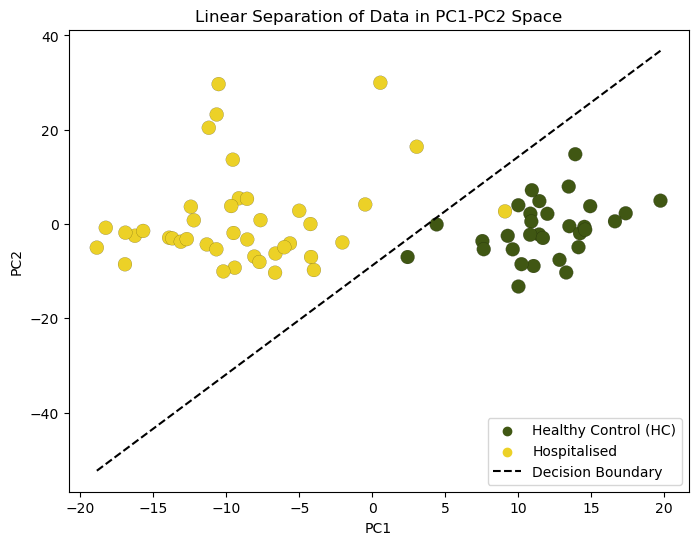

In [38]:
# Fit a SVM model
model = SVC(kernel='linear')

# Perform 4-fold cross-validation Evaluation
cv_scores = cross_val_score(model, X_train, y_train, cv=4, scoring='accuracy')

# Use cross_val_predict to get the predicted labels on the training data
y_train_pred = cross_val_predict(model, X_train, y_train, cv=4)

# Train the model on the entire training data
model.fit(X_train, y_train)

# Get the coefficients + intercept -> the weights assigned to the principal components
coef = model.coef_[0]
intercept = model.intercept_[0]

# Plotting the decision boundary on PC1 vs PC2 graph
plt.figure(figsize=(8, 6))

# Define replacement_dict based on the selected condition
if selected_condition == "All Conditions":
    replacement_dict = {'Hospitalised': '#ecd127', 'Healthy Control (HC)': '#405713'}
elif selected_condition == "Mild vs Severe":
    replacement_dict = {'Mild': '#ecd127', 'Severe': '#dc9622'}

# Scatter plot of the data points
sns.scatterplot(x='PC1', y='PC2', hue='Cohort', data=pca_data_df, palette=replacement_dict, s=100, alpha=1, linewidth=0.1, edgecolor='black')

# Plot the decision boundary
x_values = np.linspace(min(X['PC1']), max(X['PC1']), 100)
y_values = (-coef[0] / coef[1]) * x_values - (intercept / coef[1]) # reminder at the decision boundary the dot product of the coef[0]⋅pc1 +coef[1]⋅pc2 +intercept=0
# Show the decision boundary
plt.plot(x_values, y_values, linestyle='--', color='black', label='Decision Boundary')

# Add labels and title + plot
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Linear Separation of Data in PC1-PC2 Space')
plt.legend()
plt.show()


In [39]:
# Predict the test set
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the SVM regression model: {accuracy:.2f}')

Accuracy of the SVM regression model: 1.00


Again we have a strong prediction quality with the support vector machine. We can predict the condition between Healthy Control and Hospitalized with a high accuracy using the metabolomics data.

________________________
### Here we do the same but using the proteomic data

data exploration & cleaning


In [40]:
# load a 3rd table
file_name = "Proteomics.xlsx"
df_3 = pd.read_excel(file_name)

df_3.head()

,Unnamed: 0,Unnamed: 1,0.85945,-0.84454,0.39903,0.32382,0.71751,1.15539,0.92858,0.32663,...,0.28406,0.6971,1.08596,0.78105,-0.0046,0.31182,0.57787,0.0308,0.33633,0.02008
0,NaN,NaN,0,0,0,0.03409,0,0.98864,0,0,...,0,0.05682,0.95455,0,0,0,0,0,0,0
1,Sampe ID,Cohort,IL8,TNFRSF9,TIE2,MCP-3,CD40-L,IL-1 alpha,CD244,EGF,...,LAG3,IL12RB1,IL13,CCL20,TNF,KLRD1,GZMB,CD83,IL12,CSF-1
2,COVID19-HC-01,HC,4.17074,5.30054,6.82603,0.48051,3.51771,-0.8576,5.64846,6.09883,...,1.83813,0.84279,-0.67374,5.04671,2.23753,6.09023,5.03418,2.388,5.91496,8.92715
3,COVID19-HC-02,HC,5.09865,5.84809,7.17844,0.43888,5.85682,-0.77296,6.13269,7.56624,...,2.21825,1.39652,-0.92654,6.54054,2.50091,7.0803,6.02368,2.5877,6.29481,9.04075
4,COVID19-HC-04,HC,3.41338,5.1766,7.34877,0.55423,3.78825,-0.66362,5.25603,5.57761,...,1.55794,1.06955,0.63989,4.99039,2.26836,4.96152,5.44289,2.46019,6.18543,9.05436


In [41]:
#set the 3rd row as the header
df_3.columns = df_3.iloc[1, :]
# remove the first 3 rows
df_3 = df_3.iloc[2:, :]
df_3.head()

1,Sampe ID,Cohort,IL8,TNFRSF9,TIE2,MCP-3,CD40-L,IL-1 alpha,CD244,EGF,...,LAG3,IL12RB1,IL13,CCL20,TNF,KLRD1,GZMB,CD83,IL12,CSF-1
2,COVID19-HC-01,HC,4.17074,5.30054,6.82603,0.48051,3.51771,-0.8576,5.64846,6.09883,...,1.83813,0.84279,-0.67374,5.04671,2.23753,6.09023,5.03418,2.388,5.91496,8.92715
3,COVID19-HC-02,HC,5.09865,5.84809,7.17844,0.43888,5.85682,-0.77296,6.13269,7.56624,...,2.21825,1.39652,-0.92654,6.54054,2.50091,7.0803,6.02368,2.5877,6.29481,9.04075
4,COVID19-HC-04,HC,3.41338,5.1766,7.34877,0.55423,3.78825,-0.66362,5.25603,5.57761,...,1.55794,1.06955,0.63989,4.99039,2.26836,4.96152,5.44289,2.46019,6.18543,9.05436
5,COVID19-HC-05,HC,4.82615,5.31255,7.21726,1.6627,3.24737,-0.42269,5.27379,4.84446,...,2.17105,0.70205,-0.85673,4.6226,2.09606,6.17398,4.55964,2.21742,6.14237,9.27782
6,COVID19-HC-06,HC,4.50752,5.5942,6.90495,0.6144,4.90743,-0.42281,5.38784,7.35356,...,2.19672,1.56469,0.39424,7.6529,2.65521,5.51808,4.66279,2.42922,7.17093,8.97638


In [42]:
# set the first column as the rownames
df_3.index = df_3['Sampe ID']

df_3.head()

1,Sampe ID,Cohort,IL8,TNFRSF9,TIE2,MCP-3,CD40-L,IL-1 alpha,CD244,EGF,...,LAG3,IL12RB1,IL13,CCL20,TNF,KLRD1,GZMB,CD83,IL12,CSF-1
Sampe ID,,,,,,,,,,,,,,,,,,,,,
COVID19-HC-01,COVID19-HC-01,HC,4.17074,5.30054,6.82603,0.48051,3.51771,-0.8576,5.64846,6.09883,...,1.83813,0.84279,-0.67374,5.04671,2.23753,6.09023,5.03418,2.388,5.91496,8.92715
COVID19-HC-02,COVID19-HC-02,HC,5.09865,5.84809,7.17844,0.43888,5.85682,-0.77296,6.13269,7.56624,...,2.21825,1.39652,-0.92654,6.54054,2.50091,7.0803,6.02368,2.5877,6.29481,9.04075
COVID19-HC-04,COVID19-HC-04,HC,3.41338,5.1766,7.34877,0.55423,3.78825,-0.66362,5.25603,5.57761,...,1.55794,1.06955,0.63989,4.99039,2.26836,4.96152,5.44289,2.46019,6.18543,9.05436
COVID19-HC-05,COVID19-HC-05,HC,4.82615,5.31255,7.21726,1.6627,3.24737,-0.42269,5.27379,4.84446,...,2.17105,0.70205,-0.85673,4.6226,2.09606,6.17398,4.55964,2.21742,6.14237,9.27782
COVID19-HC-06,COVID19-HC-06,HC,4.50752,5.5942,6.90495,0.6144,4.90743,-0.42281,5.38784,7.35356,...,2.19672,1.56469,0.39424,7.6529,2.65521,5.51808,4.66279,2.42922,7.17093,8.97638


In [43]:
#check that df_3 has no nan values
nan_values = df_3.isna().sum().sum()
print("Number of NaN values in df_3:", nan_values)

Number of NaN values in df_3: 0


we have high quality data with no missing values. We can directly use the data for the analysis.

In [44]:
#save df_3, that contains the proteomics data, in a csv file
df_3.to_csv("Proteomics.csv")

We perform a UMAP on the proteomic data to see whether each different cohort can cluster together. We use the UMAP to reduce the dimensionality of the data and plot the data in 2D.

c:\Users\gross\anaconda3\envs\bioinfoWG\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


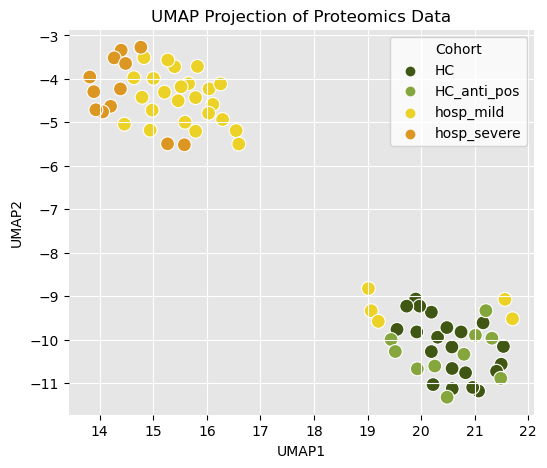

In [45]:
# Load the data
data = pd.read_csv('Proteomics.csv') 

# Select numeric data for UMAP
data_numeric = data.select_dtypes(include=[float, int])

# Set up and fit UMAP
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    n_components=2,
    random_state=random_state
)
embedding = reducer.fit_transform(data_numeric)

# Create a DataFrame for plotting
umap_data = pd.DataFrame(embedding, columns=['UMAP-1', 'UMAP-2'])
umap_data['Cohort'] = data['Cohort']

# choose colors for the dots
replacement_dict = {
    'hosp_mild': '#ecd127',
    'hosp_severe': '#dc9622',
    'HC_anti_pos': '#85a63d',
    'HC': '#405713'
}


# Plotting
plt.figure(figsize=(6, 5))
sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='Cohort', data=umap_data,  palette=replacement_dict, s=100, alpha=1)

#set labels
xlabel = plt.xlabel('UMAP1')
ylabel = plt.ylabel('UMAP2')
#put a gray background
plt.gca().set_facecolor("#e6e6e6")
#add a white grid
plt.grid(color='white')
#remove the black frame
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.title('UMAP Projection of Proteomics Data')
plt.legend(title='Cohort')
plt.show()


Similar to the metabolomics data, we Healthy control and Hospitalized control are clustering apart, while the Mild and Severe cohort are clustering together.